## **Содержание**
1) Введение
2) Математическое описание KNN
3) Переобучение KNN
4) Как предобрабатывать данные для модели
5) Применение модели на практике. Где, почему, плюсы, минусы
6) Реализация KNN - классификатора
7) Реализация KNN - регрессора
8) Как контролировать обучение модели
9) Обучение KNN-классификатора на подготовленом датасете
10) Сравнение результатов с реализацией в sklearn

# **Введение**

KNN является метрическим алгоритмом классического машинного обучения. Хотя от обучения здесь мало чего есть. Такие алгоритмы просто запоминают обучающую выборку и относительно неё определяют расстояния до новых объектов.

KNN может применяться как для классификации, так и для регрессии.

Вычислительнаю сложность метода KNN можно описать как O(N * M), где N - количество объектов в обучающей выборке, а M - количество признаков.

# **Математическое описание KNN**

## **Задача классификации**

Допустим у нас есть обучающая выборка 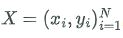, где . Также нам дана метрика расстояния . Нам нужно классифицировть объект *u*


Для этого найдём k самых близких к *u* объектов относительно данной метрики. 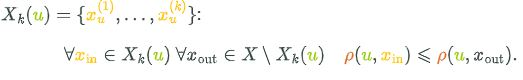

Класс нового объекта определим как наиболее часто встречающийся класс среди k соседей. 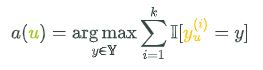

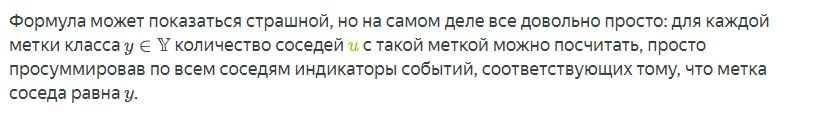

Тогда вероятность принадлежности объекта к классу: 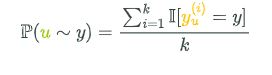

## **Задача регрессии**

Для регрессии у нас также есть обучающая выборка, метрика расстояния. Мы так же ищем k ближайших соседей. Однако теперь нам необходимо предсказать не класс объекта, а некое число, не категориальное значение, а численное - непрерывное. Здесь может помочь обучное усреднение. 

Мы усредняем y k ближайших соседей и считаем это ответом. 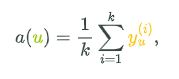

## **Взвешенный KNN**

Классические алгоритм очень прост, но он не использет всю предоставленную нам информацию, а именно, не использует расстояние от объекта до соседей. 

Эту проблему можно решить, задав функцию, которая даёт больший вес тем соседям, которые ближе к объекту.

Требования к такой функции следующие: 1) Положительная 2) Монотонно убывающая

Функции , удовлетворяющие этим свойствам называются ядерными функциям (kernel function)

Тогда итоговый класс высчитывается по формуле Надарая-Ватсона 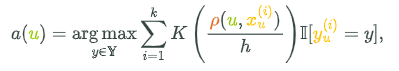. Где h - положительное число, называющееся шириной окна

Ширина окна, в свою очередь, сильно влияет как раз на качество модели. При слишком маленькой ширине модель сильно подстраивается под обучающую выборку и теряет свою обобщающую способность. При слишком большой ширине, напротив, модель становится слишком простой. Универсальной ширины окна не существует, поэтому для каждой задачи её приходится подбирать отдельно.

А для задачи регрессии используется формула ядерного сглаживания Надарая Ватсона 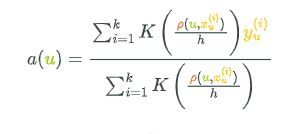

Вывод формулы ядерного сглаживания Надарая-Ватсона 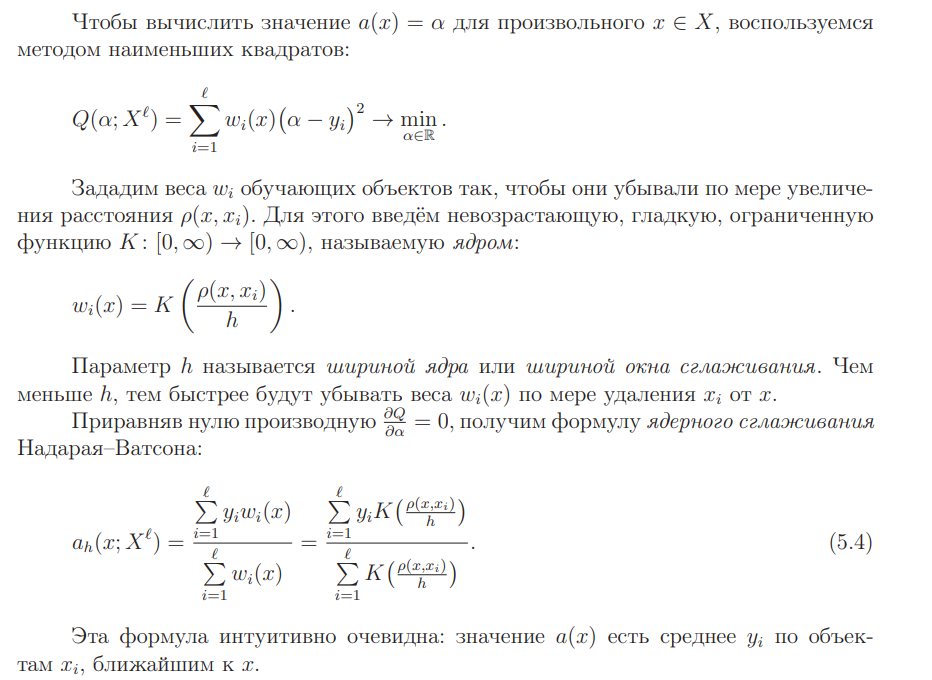

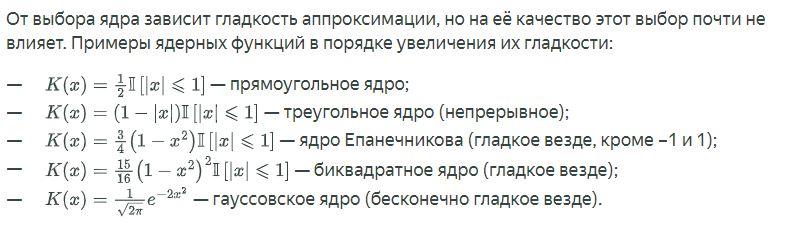

На практике чаще всего используют либо прямоугольное для простоты, либо гауссовское, в случае когда важна гладкость модели (это особенно важно в регрессии).

## **Выбор метрики**

Кроме евклидового расстояния между векторами, есдь множество других метрик.
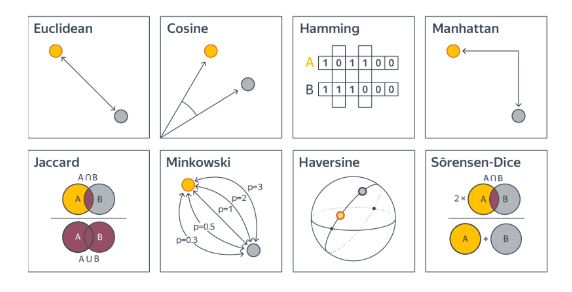 

 Евклидово расстояние 

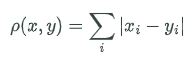 Манхэттенская метрика

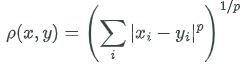 Метрика Минковского

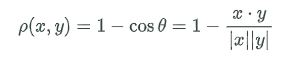 Косинусное расстояние

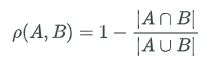 Расстояние Жаккара

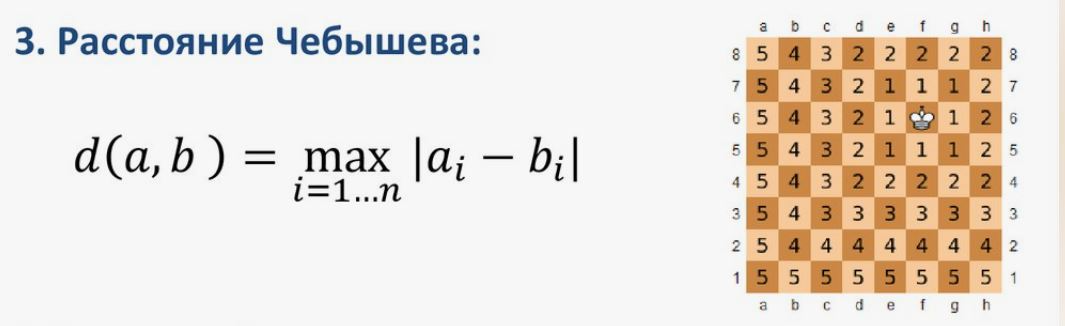

## **Переобучение**

Переобучение - очень странное понятие для KNN, у которого обучение отсутствует. Скорее, можно подобрать гиперпараметры (k, h, ядро и т.д) KNN так, что его результат будет зависеть от выбросов или соседей

## **Как предобрабатывать данные для модели**

Так как knn - метрический алгоритм, то на результат его работы сильно влияет масштаб данных относительно друг друга. Если один признак буде кратен 100, а другой меньше 10, то именно первый будет решать, каково расстояние одного объекта до другого. Непраильно масштабированные данные ведут к неправильной интерпритации моделью важности признаков.

!Для метрических алгоритмов НЕОБХОДИМО масштабировать данные. 

Как это делать описано здесь: Datasets\Classification\dataset.ipynb

Если кратко, то есть множество способов, но основных всего несколько:
1) Min Max Scaler
2) Standart Scaler (Z-Scaler)
3) Robust Scaler

У каждого есть свои преимущества и недостатки каждый предназначен для разных распределений данных, кждый по разному устойчив к выбросам.

Например датасет, на котором будет тестироваться KNN обработат MinMAx нормализацией.

## **Применение на практике**

Алгоритм неэффективен на очень больших объёмах данных из-за своей вычислительной сложности и занимаемой памяти. KNN не выявляет закономерностей о распределении данных. Чувствителен к масштабу и информативности данных.

И всё-таки, KNN до сих пор применяется в следующих задачах: 

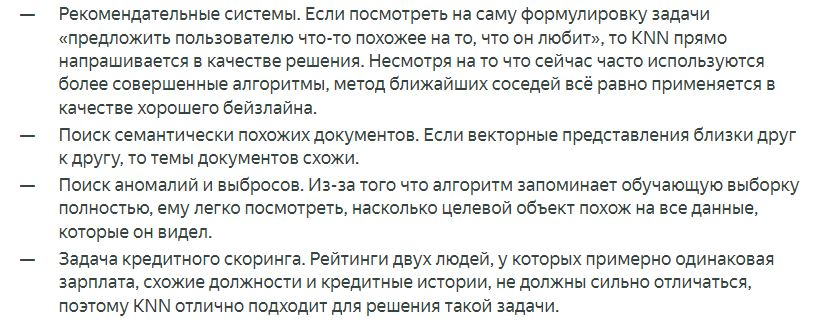


# **Реализация KNN классификатора**

In [1]:
import numpy as np

In [2]:
class KNN:
    """
    Параметры:
    1) k: int - количество соседей. По умолчанию 3
    2) metric: str, опционально - способ оценки расстояния между объектами. Поддерживаемые значения: 
       'euclidean' (по умолчанию), 'manhattan', 'minkowski', 'chebyshev', 'cosinus'.
    3) weight_func: callable, опционально - функция, принимающая на вход расстояния от объекта x из тестовой выборки 
       до всех объектов из train выборки и возвращающая веса каждого объекта. 
       Может также принимать ядерную функцию и окно h.
       Если используется метод Парзеновского окна с постоянной h типа float.
       Если h - функция, нужно передать callable.
       Пример:  def weight_func(dists, h, kernel):
                   return kernel(dists/h)
            model = KNN(weight_func=weight_func, h = 0.5, kernel='epanechnikov')
    4) h: float или callable, опционально - окно для метода Парзеновского окна. Игнорируется, если weight_func не использует h.
       Если h - функция, передать callable.
    5) kernel: str, callable, опционально - ядерная функция для метода Парзеновского окна. Поддерживаемые значения:
       'rectangular', 'triangular', 'epanechnikov', 'quartic', 'gaussian'.
       Если ядерная функция предоставляется через weight_func, этот параметр игнорируется.
    """
    def __init__(self, k = 3, metric = 'euclidean', weight_func = None, h = None, kernel = 'None'):
        self.k = k
        self.metric = metric
        self.weight_func = weight_func
        self.distance = {
            'euclidean': lambda x,y: np.sqrt(np.sum(np.square(x-y))),
            'manhattan': lambda x, y: np.sum(np.abs(x-y)),
            'minkowski': lambda x, y: np.power(np.sum(np.abs(x - y) ** (len(x))), 1/(len(x))),
            'chebyshev': lambda x, y: np.max(np.abs(x-y)),
            'cosinus': lambda x, y: 1 - np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))
        }[metric]
        self.h = h
        self.kernel = {
            'rectangular': lambda r: 0.5*((np.abs(r) <= 1).astype(float)),
            'triangular': lambda r: (1 - np.abs(r))*(np.abs(r) <= 1).astype(float),
            'epanechnikov': lambda r: 0.75 * (1 - r**2) * ((np.abs(r) <= 1).astype(float)),
            'quartic': lambda r: ((15/16)*(1-r**2)**2)*(np.abs(r) <= 1).astype(float),
            'gaussian': lambda r: (1/np.sqrt(2 * np.pi)) * np.exp(-2 * r**2),
            'None': None
        }[kernel]

    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, X):
        predictions = []
        for x in X:
            dists = np.array([self.distance(x,y) for y in self.X])
            if self.weight_func:
                if self.h and self.kernel:
                    weights = self.weight_func(dists, self.h, self.kernel)
                    neighbors = np.argsort(dists)[:]
                else:
                    neighbors = np.argsort(dists)[:self.k+1]
                    k_dists = dists[neighbors]
                    weights = self.weight_func(k_dists)
                    
                predictions.append(np.argmax(np.bincount(self.y[neighbors], weights=weights[neighbors])))
                    
            else:
                neighbors = self.y[dists.argsort()[:self.k]]
                predictions.append(np.argmax(np.bincount(neighbors)))

        return np.array(predictions)
                
            

In [3]:
def parzen_window(dists, h, kernel):
    return kernel(dists/h)

def index_weighted(dists):
    weights = []
    k = len(dists)
    for i in range(k):
        weights.append((k+1-i)/k)
    return weights

# **Проверка KNN на датасете**

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('../Datasets/Classification/train.csv')

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns ='price_range'), df['price_range'], test_size=0.2, random_state=42)

In [5]:
X_train = X_train.to_numpy()
X_test  = X_test.to_numpy()
y_train= y_train.to_numpy()
y_test= y_test.to_numpy()

In [6]:
knn = KNN()

knn.fit(X_train, y_train)

In [7]:
X_train

array([[1.923e+03, 0.000e+00, 5.000e-01, ..., 1.000e+00, 1.000e+00,
        1.000e+00],
       [6.330e+02, 1.000e+00, 2.200e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00],
       [1.236e+03, 0.000e+00, 9.000e-01, ..., 1.000e+00, 0.000e+00,
        1.000e+00],
       ...,
       [1.829e+03, 1.000e+00, 5.000e-01, ..., 1.000e+00, 0.000e+00,
        1.000e+00],
       [1.927e+03, 0.000e+00, 9.000e-01, ..., 0.000e+00, 1.000e+00,
        1.000e+00],
       [6.350e+02, 1.000e+00, 6.000e-01, ..., 1.000e+00, 0.000e+00,
        0.000e+00]])

In [8]:
knn.predict(X_test)

array([0, 2, 1, 3, 1, 1, 2, 0, 3, 1, 0, 1, 2, 3, 2, 2, 3, 3, 1, 0, 0, 1,
       1, 2, 0, 1, 3, 2, 2, 0, 0, 0, 3, 0, 1, 1, 2, 0, 3, 0, 2, 3, 2, 0,
       2, 2, 2, 1, 3, 1, 3, 1, 0, 0, 0, 0, 1, 3, 0, 0, 1, 3, 3, 1, 0, 0,
       3, 3, 1, 2, 2, 2, 0, 1, 2, 0, 0, 3, 2, 2, 3, 2, 1, 0, 1, 3, 1, 3,
       3, 0, 3, 3, 2, 1, 3, 2, 2, 3, 1, 1, 0, 0, 1, 0, 1, 3, 2, 0, 1, 1,
       0, 0, 3, 1, 2, 2, 3, 2, 0, 2, 1, 3, 2, 1, 3, 3, 0, 3, 0, 2, 3, 0,
       2, 2, 0, 3, 1, 0, 0, 2, 2, 1, 2, 2, 0, 0, 0, 1, 1, 2, 3, 1, 1, 0,
       2, 2, 0, 2, 0, 2, 2, 3, 3, 2, 1, 0, 1, 2, 2, 3, 3, 0, 1, 0, 3, 1,
       1, 2, 1, 0, 0, 0, 0, 0, 3, 2, 0, 3, 0, 0, 0, 0, 1, 3, 2, 1, 0, 1,
       1, 1, 1, 1, 2, 3, 3, 3, 1, 2, 0, 0, 0, 2, 1, 1, 3, 1, 0, 3, 1, 1,
       3, 2, 3, 0, 0, 2, 1, 3, 0, 1, 2, 0, 2, 3, 2, 0, 1, 3, 3, 0, 1, 3,
       2, 3, 0, 3, 1, 2, 3, 3, 2, 1, 0, 3, 3, 1, 3, 3, 3, 3, 3, 0, 2, 2,
       2, 1, 3, 0, 1, 3, 2, 3, 2, 1, 0, 1, 0, 3, 3, 1, 3, 1, 0, 3, 1, 2,
       0, 0, 3, 0, 1, 2, 3, 3, 3, 1, 1, 0, 1, 3, 3,

In [9]:
from sklearn.metrics import accuracy_score
 
print(accuracy_score(y_test, knn.predict(X_test)))

0.9275


**Сравним с реализацией в sklearn**

In [10]:
from sklearn.neighbors import KNeighborsClassifier

sk_knn = KNeighborsClassifier()

sk_knn.fit(X_train, y_train)

sk_preds = sk_knn.predict(X_test)

In [11]:
print(accuracy_score(y_test, sk_preds))

0.9425


**Переберём разные метрики расстояния: ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'cosinus'] а также переберём k [1,20] для уже имеющегося разбиения X,y на тренировочную и тестовую выборки**


In [12]:
import matplotlib.pyplot as plt

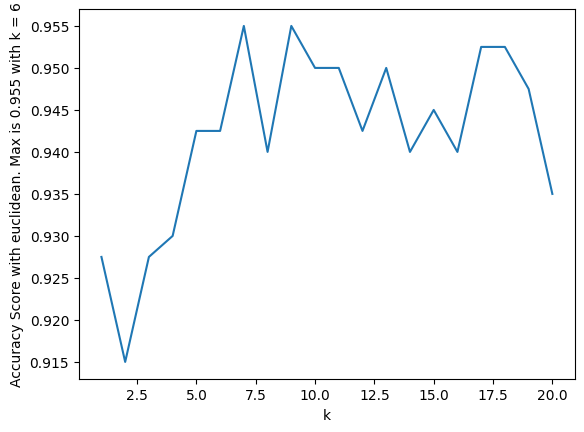

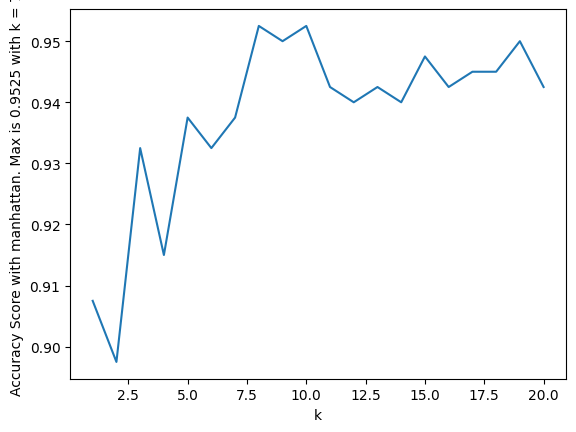

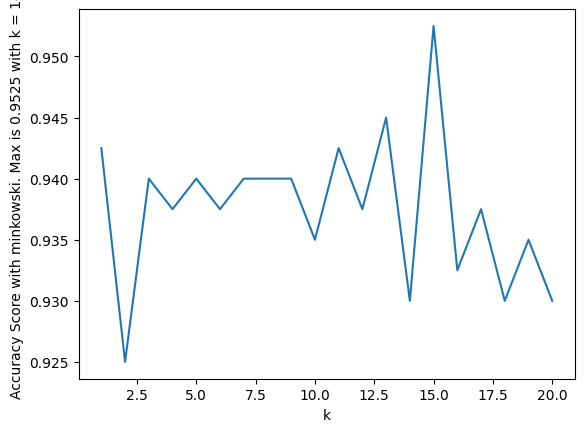

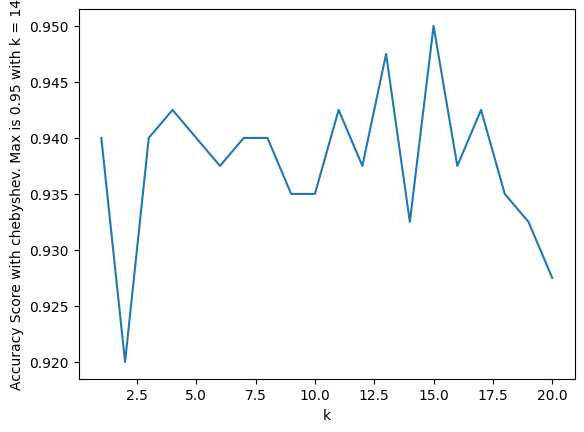

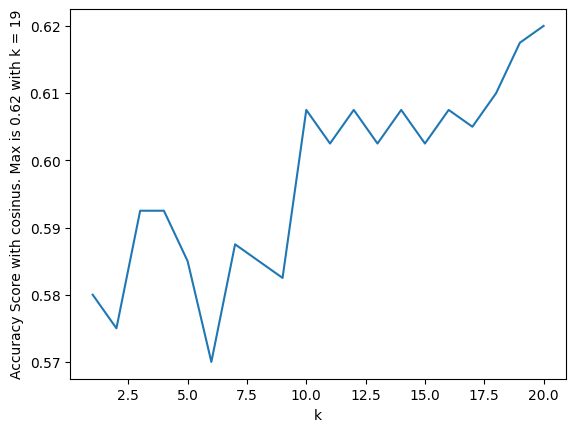

In [13]:
k_range = list(range(1,21))
for metric in ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'cosinus']:
    acc_scores = []
    for k in k_range:
        knn = KNN(k, metric)
        knn.fit(X_train, y_train)
        acc_scores.append(accuracy_score(y_test, knn.predict(X_test)))
    plt.plot(k_range, acc_scores)
    plt.xlabel('k')
    plt.ylabel(f'Accuracy Score with {metric}. Max is {max(acc_scores)} with k = {np.argmax(acc_scores)}')
    plt.show()

Как и ожидалось, наилучшим образом себя показала евклидова метрика. k = 6

In [14]:
sk_knn = KNeighborsClassifier(metric='euclidean', n_neighbors = 9)
sk_knn.fit(X_train, y_train)
print(accuracy_score(y_test, sk_knn.predict(X_test)))

0.955


Такой же accuracy_score sklernовский knn достигает при k = 9, при остальных - меньше

**Переберём разные ядра: ['rectangular', 'triangular', 'epanechnikov, 'quartic', 'gaussian'] а также величину Парзеновского окна h [1, 10, 20, 30 ,40, 50, 60, 70, 80, 90, 100, 110, 150, 200, 250, 400, 500]**

In [15]:
def parzen_window(dists, h, kernel):
    return kernel(dists/h)

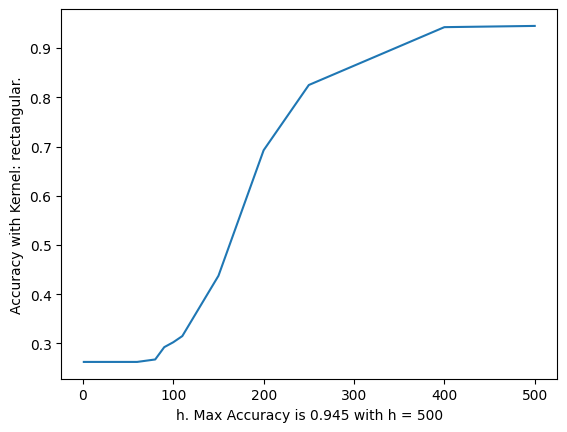

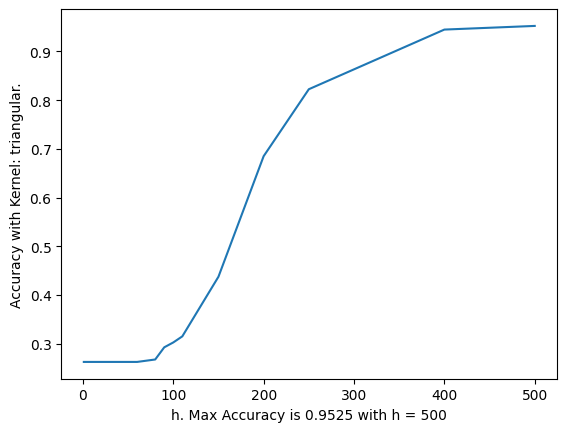

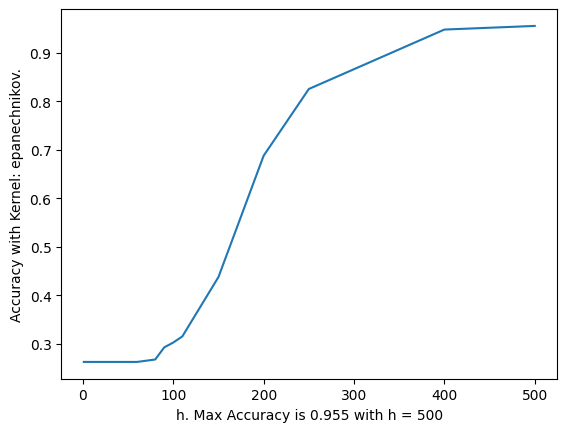

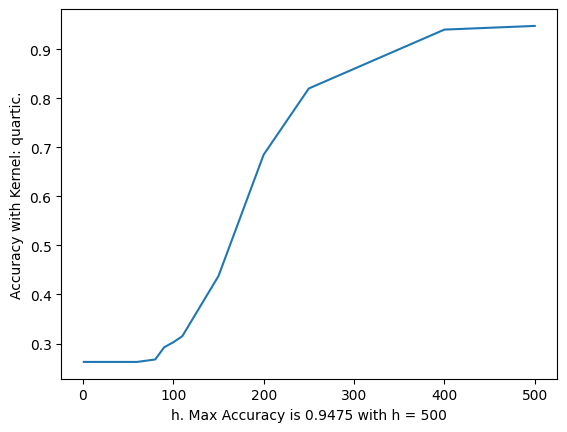

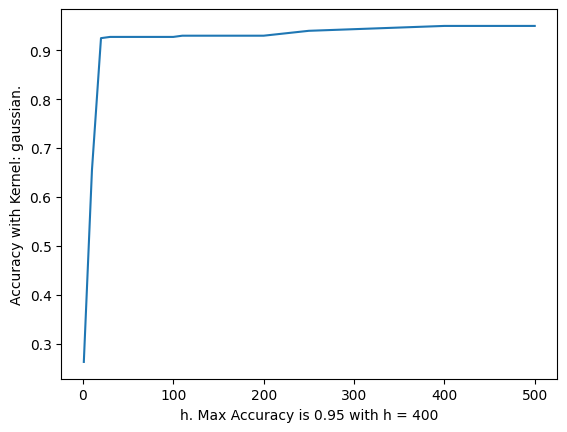

In [16]:
h_range = [1, 10, 20, 30 ,40, 50, 60, 70, 80, 90, 100, 110, 150, 200, 250, 400, 500]
for kernel in ['rectangular', 'triangular', 'epanechnikov', 'quartic', 'gaussian']:
    acc_scores = []
    for h in h_range:
        knn = KNN(weight_func=parzen_window, kernel=kernel, h = h)
        knn.fit(X_train, y_train)
        acc_scores.append(accuracy_score(y_test, knn.predict(X_test)))
    plt.plot(h_range, acc_scores)
    plt.xlabel(f'h. Max Accuracy is {max(acc_scores)} with h = {h_range[np.argmax(acc_scores)]}')
    plt.ylabel(f'Accuracy with Kernel: {kernel}.')
    plt.show()

Очень интересно наблюдать за тем, как ведёт себя метрика при разных ядерных функциях. Поведение ядра 'gaussian' отличается от других. Это связано с тем, что gaussian не принимает значение 0, если ему передается значение не принадлежащеее отрезку [0,1]. При этом у гауссиан единственный h, которому достаточно 400

Точно ясно одно надо рассматриать значения h >= 500. Повторим эксперимент

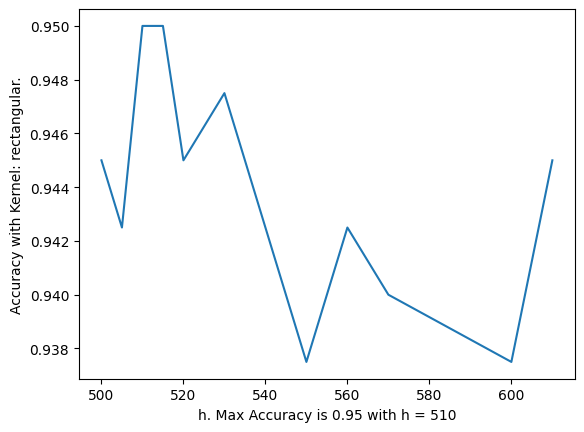

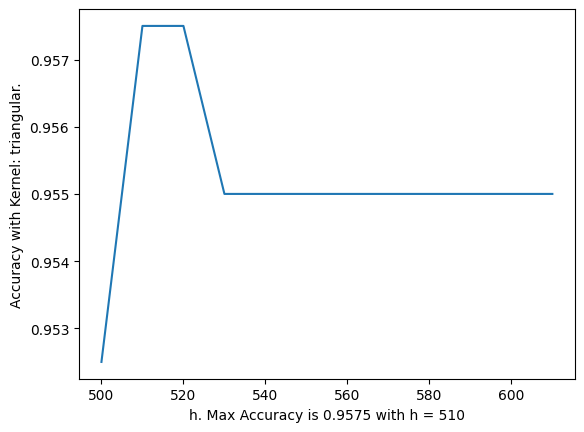

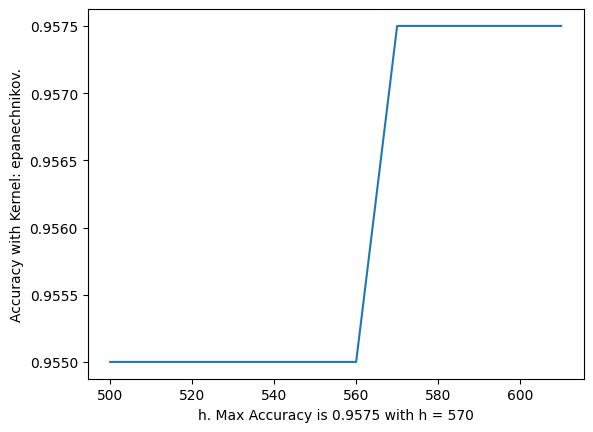

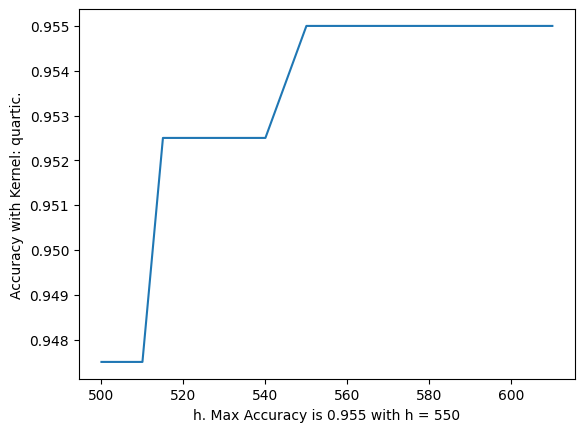

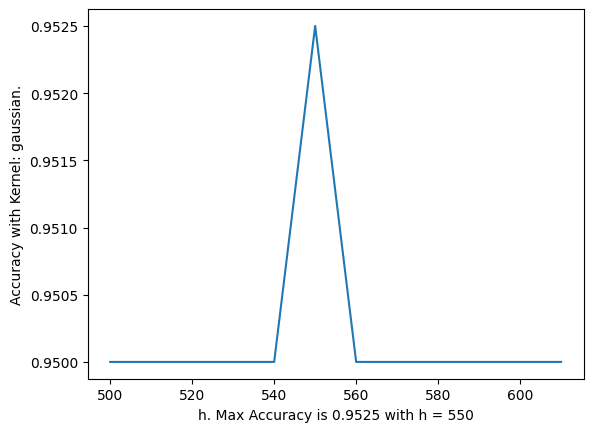

In [17]:
h_range = [500, 505, 510, 515, 520, 530, 540, 550, 560, 570, 600, 610]
for kernel in ['rectangular', 'triangular', 'epanechnikov', 'quartic', 'gaussian']:
    acc_scores = []
    for h in h_range:
        knn = KNN(weight_func=parzen_window, kernel=kernel, h = h)
        knn.fit(X_train, y_train)
        acc_scores.append(accuracy_score(y_test, knn.predict(X_test)))
    plt.plot(h_range, acc_scores)
    plt.xlabel(f'h. Max Accuracy is {max(acc_scores)} with h = {h_range[np.argmax(acc_scores)]}')
    plt.ylabel(f'Accuracy with Kernel: {kernel}.')
    plt.show()

Лучше всего себя показало треугольное ядро с h = 570. Accuracy составил 0.9575.

Проверим, как окно Парзена будет работать в sklearnовской реализации.

In [18]:
kernels = {
            'rectangular': lambda r: 0.5*((np.abs(r) <= 1).astype(float)),
            'triangular': lambda r: (1 - np.abs(r))*(np.abs(r) <= 1).astype(float),
            'epanechnikov': lambda r: 0.75 * (1 - r**2) * ((np.abs(r) <= 1).astype(float)),
            'quartic': lambda r: ((15/16)*(1-r**2)**2)*(np.abs(r) <= 1).astype(float),
            'gaussian': lambda r: (1/np.sqrt(2 * np.pi)) * np.exp(-2 * r**2),
        }

def parzen_window(dists):
    return kernel(dists/h)

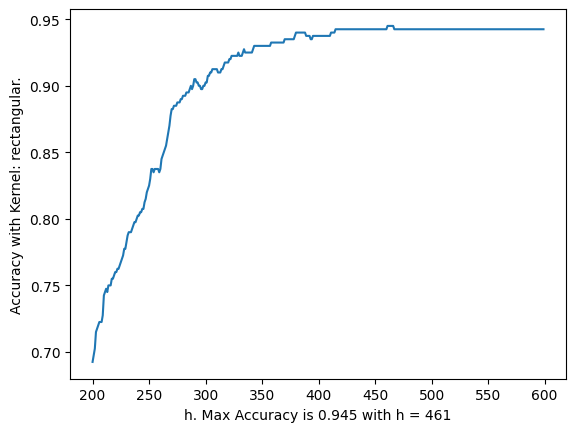

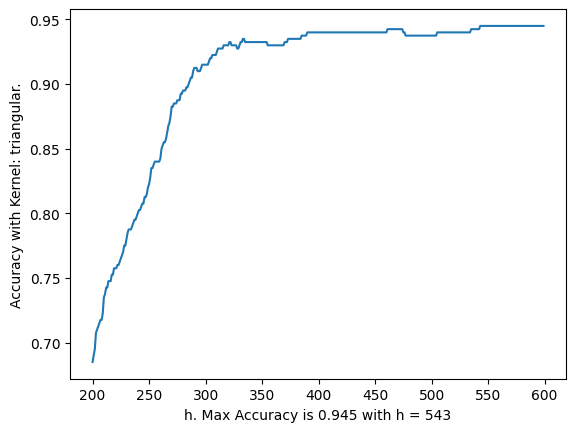

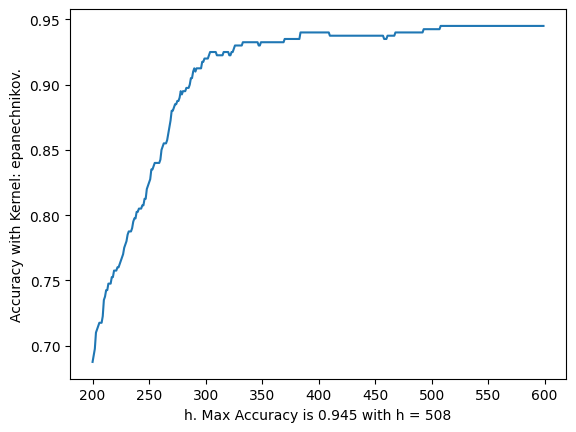

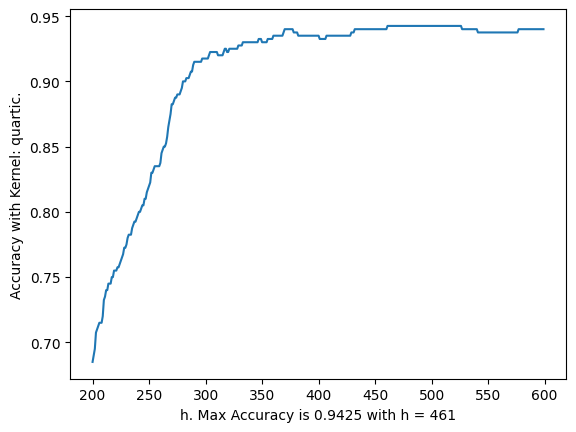

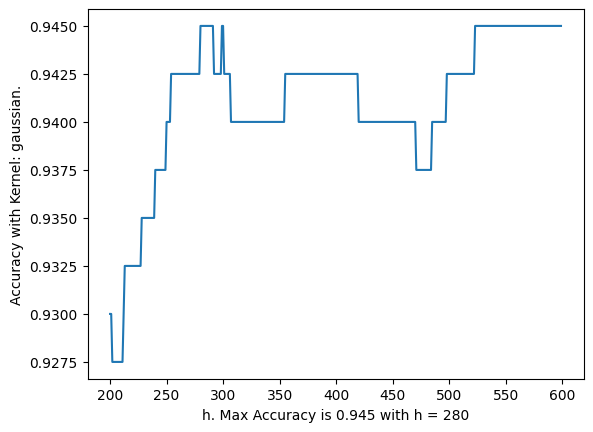

In [19]:
h_range = list(range(200, 600))
for kernel in ['rectangular', 'triangular', 'epanechnikov', 'quartic', 'gaussian']:
    acc_scores = []
    for h in h_range:

        def parzen_window(dists):
            return kernels[kernel](dists/h)
        
        knn = KNeighborsClassifier(weights=parzen_window)
        knn.fit(X_train, y_train)
        acc_scores.append(accuracy_score(y_test, knn.predict(X_test)))
    plt.plot(h_range, acc_scores)
    plt.xlabel(f'h. Max Accuracy is {max(acc_scores)} with h = {h_range[np.argmax(acc_scores)]}')
    plt.ylabel(f'Accuracy with Kernel: {kernel}.')
    plt.show()

Так как sklearnщвская реализация работает намного быстрее, можно более скурпулезно подбирать h. Однако, каким бы он ни был, почему-то окно Парзена в данной реализации работет хуже, чем в моей. 
Здесь accuracy составляет 0.945 против 0.9575 моей.

Возможно, это происходит из-за того, что этот KNN устроен сложнее. В его работе участвуют такие сущности как K-d-деревья (k-dimensional tree). Наверняка именно они влияют на работу и на результат модели в sklearn.

*Представим на секунду, что у нас есть всего лишь один признак, то есть объекты выражаются вещественными числами, а не векторами. В этом случае для поиска ближайшего соседа напрашивается всем вам известное бинарное дерево поиска, которое позволяет находить элементы за логарифмическое время. Оказывается, существует аналог данной структуры в многомерном пространстве, который называется k-d-дерево (k-d tree сокращение от k-dimensional tree).* - учебник ШАДа

(https://youtu.be/kAcRrzKk88M?si=tI1gJexVMlQH6LKL) - лекция по k-d деревьям